# Tactical Asset Allocation

In [1]:
%%capture
%reload_ext autoreload
%autoreload 2
%cd ..
%cd src

In [2]:
from pytaa.tools.data import get_strategy_price_data
from pytaa.strategy.static import STRATEGIES
from pytaa.strategy.strategies import StrategyPipeline
from pytaa.strategy.signals import Signal
from pytaa.backtest.positions import (
    EqualWeights, RiskParity, vigilant_allocation, kipnis_allocation, aqr_trend_allocation
)
from pytaa.backtest.performance import Tearsheet
from pytaa.backtest.returns import Backtester


import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [3]:
start, end = "2011-01-01", "2023-05-01"
rebalance_dates = pd.bdate_range(start, end, freq="BM")

pipeline = StrategyPipeline(STRATEGIES)
data = get_strategy_price_data(pipeline, start, end).dropna()

In [4]:
all_strategies = []

# ivy
strategy = pipeline.ivy
strategy_data = data[strategy.risk_assets]
signals = Signal(strategy_data).sma_crossover(10).dropna()

weights = signals.apply(lambda x: np.where(x > 0, strategy.weights[0], 0))
weights.loc[:, strategy.safe_assets] = 1 - weights.sum(axis=1)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# benchmark strategies
assets = ["SPY", "AGG", "IEF", "GLD", "EEM"]
returns = data.pct_change().dropna().loc[:, assets]

ew = EqualWeights(assets, rebalance_dates).weights
rp = RiskParity(assets, rebalance_dates, returns).weights
all_strategies.append([ew, rp])

# robust asset allocation
strategy = pipeline.raab
strategy_data = data[strategy.get_tickers()]
signal_1 = Signal(strategy_data).classic_momentum(end=0).dropna()
signal_2 = Signal(strategy_data).sma_crossover(12, False).dropna()
cond_1 = np.where(signal_1[strategy.risk_assets].gt(signal_1[strategy.safe_assets].values), 1, 0)
cond_2 = np.where(strategy_data.reindex(signal_2.index) > signal_2, 1, 0)[:,:-1]
final_signal = cond_1 + cond_2
cash = np.atleast_2d(len(strategy.risk_assets) - np.sum(final_signal / 2, 1)).T
idx, cols = signal_1.index, signal_1.columns
weights = pd.DataFrame(np.hstack([final_signal, cash]), index=idx, columns=cols)
weights = weights.div(weights.sum(axis=1).values.reshape(-1, 1))
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# vigilant asset allocation g12
strategy = pipeline.vaag12
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score()
args = (strategy.risk_assets, strategy.safe_assets)
weights = pd.concat([x for x in signal.apply(lambda x: vigilant_allocation(x, *args), axis=1)])
weights.index = signal.index
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# vigilant asset allocation g4
strategy = pipeline.vaag4
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score()
args = (strategy.risk_assets, strategy.safe_assets, 1, 1)
weights = pd.concat([x for x in signal.apply(lambda x: vigilant_allocation(x, *args), axis=1)])
weights.index = signal.index
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# gem dual momentum
strategy = pipeline.gdm
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).classic_momentum(start=12, end=0)
cond_1, cond_2 = signal["SPY"].ge(signal["BIL"]), signal["SPY"].ge(signal["EFA"])
spy = np.where(cond_1 & cond_2, 1, 0).reshape(-1,1)
efa = np.where(cond_1 & ~cond_2, 1, 0 ).reshape(-1,1)
agg = np.where(~cond_1, 1, 0).reshape(-1,1)
weights = pd.DataFrame(np.hstack([spy, efa, agg]), index=signal.index, columns=["SPY", "EFA", "AGG"])
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# diversified gem dual momentum
strategy = pipeline.dgdm
strategy_data = data[strategy.get_tickers()]
mom_periods = [6, 7, 8, 9, 10, 11, 12]
monthly = strategy_data.resample("BM").last()
spy, agg = np.zeros((monthly.shape[0], 1)), np.zeros((monthly.shape[0], 1))
efa = np.zeros((monthly.shape[0], 1))

for w in mom_periods:
    signal = Signal(strategy_data).classic_momentum(start=w, end=0)
    cond_1, cond_2 = signal["SPY"].ge(signal["AGG"]), signal["SPY"].ge(signal["EFA"])
    spy += np.where(cond_1 & cond_2, 1, 0).reshape(-1,1)
    efa += np.where(cond_1 & ~cond_2, 1, 0 ).reshape(-1,1)
    agg += np.where(~cond_1, 1, 0).reshape(-1,1)
idx, cols = monthly.index, monthly.columns
weights = pd.DataFrame(np.hstack([spy, efa, agg]) / len(mom_periods), index=idx, columns=cols)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# kipnis defensive asset allocation
strategy = pipeline.kdaaa
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score().dropna()
returns = strategy_data.pct_change()
weights = kipnis_allocation(returns, signal, rebalance_dates, strategy.safe_assets, strategy.risk_assets, strategy.safe_assets)
weights.columns.name, weights.index.name = "ID", "Date"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# trend is our friend
strategy = pipeline.tiof
strategy_data = data[strategy.get_tickers()]
returns = strategy_data.pct_change()
signal = Signal(strategy_data).sma_crossover(lookback=10)
weights = aqr_trend_allocation(returns, signal, rebalance_dates, strategy.risk_assets, "BIL")
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# concat all strats
all_strategies = reduce(lambda x, y: x.join(y, how="outer"), all_strategies).fillna(0)

In [5]:
bt = Backtester(all_strategies, "USD")
port_total_returns = bt.run(return_type="total")
port_total_returns.add(1).cumprod().tail()

,IVY,EW,RP,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA,TIOF
Date,,,,,,,,,,
2022-12-30,1.754711,1.524680,1.247961,2.029017,1.346247,1.277291,2.285366,2.340897,1.187843,1.516681
2023-01-31,1.759507,1.602311,1.304842,2.003708,1.349926,1.280782,2.351813,2.445899,1.224180,1.520827
2023-02-28,1.732300,1.535189,1.253790,1.960867,1.297387,1.250530,2.289317,2.382667,1.168261,1.504022
2023-03-31,1.749544,1.594774,1.298774,1.962370,1.302849,1.255795,2.338496,2.434269,1.205151,1.517309
2023-04-28,1.758973,1.595912,1.299071,1.999632,1.305324,1.293195,2.339930,2.438113,1.217450,1.521707


In [6]:
port_price_returns = bt.run(return_type="price")
port_price_returns.add(1).cumprod().tail()

,IVY,EW,RP,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA,TIOF
Date,,,,,,,,,,
2022-12-30,1.519112,1.300561,1.042491,1.701336,1.173509,1.124134,1.887710,1.831064,1.005366,1.316195
2023-01-31,1.523264,1.366781,1.090006,1.680114,1.176716,1.127206,1.942595,1.913198,1.036121,1.319792
2023-02-28,1.496750,1.308319,1.046055,1.642893,1.130919,1.100581,1.886384,1.859862,0.988792,1.301573
2023-03-31,1.507242,1.356866,1.081661,1.637263,1.132522,1.102142,1.922247,1.895158,1.017911,1.309066
2023-04-28,1.512155,1.356616,1.080596,1.667569,1.132059,1.134965,1.918581,1.894058,1.027829,1.308929


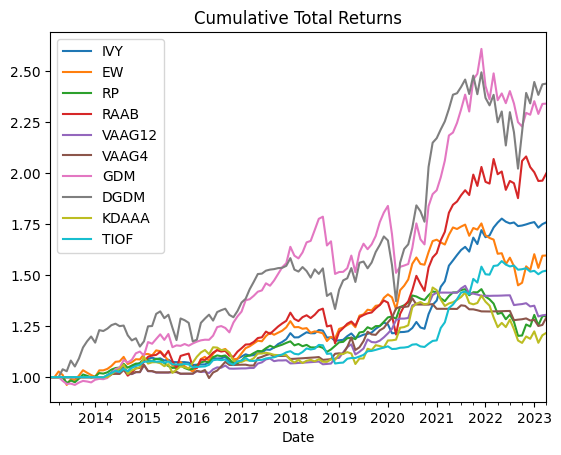

In [7]:
port_total_returns[port_total_returns.index >= "2013-02-01"].add(1).cumprod().plot(title="Cumulative Total Returns");

In [9]:
ts = Tearsheet(port_total_returns[port_total_returns.index >= "2013-02-01"], "EW")
ts.summary(ann_factor=12).round(2)

,IVY,EW,RP,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA,TIOF
#obs,123.00,123.00,123.00,123.00,123.00,123.00,123.00,123.00,123.00,123.00
#years,10.16,10.16,10.16,10.16,10.16,10.16,10.16,10.16,10.16,10.16
Total Return,0.76,0.60,0.30,1.00,0.31,0.29,1.34,1.44,0.22,0.52
Annual Return,0.06,0.05,0.03,0.07,0.03,0.03,0.09,0.09,0.02,0.04
Volatility,0.05,0.08,0.05,0.10,0.04,0.05,0.11,0.14,0.07,0.05
Max Drawdown,-0.04,-0.17,-0.16,-0.13,-0.10,-0.10,-0.18,-0.19,-0.19,-0.08
Skewness,0.73,-0.04,-0.27,0.04,0.05,-0.04,-0.68,0.21,0.07,0.99
Kurtosis,5.63,3.37,4.67,4.71,6.80,5.87,5.59,4.69,4.31,8.47
Sharpe Ratio,1.12,0.62,0.50,0.75,0.61,0.55,0.80,0.68,0.31,0.89
Standard Error,0.33,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.31,0.33


In [17]:
ts.summary()

[autoreload of pytaa.backtest.performance failed: Traceback (most recent call last):
  File "/Users/claudio/projects/envs/dev/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/Users/claudio/projects/envs/dev/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/claudio/projects/envs/dev/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/Users/claudio/projects/envs/dev/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 333, in update_class
    if update_generic(old_obj, new_obj):
  File "/Users/claudio/projects/envs/dev/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/Users/claudio/projects/envs/dev/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 293

,IVY,EW,RP,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA,TIOF
#obs,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
#years,10.160164,10.160164,10.160164,10.160164,10.160164,10.160164,10.160164,10.160164,10.160164,10.160164
Total Return,0.758973,0.595912,0.299071,0.384450,0.305324,0.293195,1.339930,1.476946,0.217450,0.521707
Annual Return,0.057157,0.047082,0.026087,0.032536,0.026572,0.025629,0.087272,0.093379,0.019554,0.042187
Volatility,0.050381,0.078276,0.054404,0.099211,0.044340,0.047907,0.112263,0.097907,0.070758,0.047532
Max Drawdown,-0.043462,-0.172941,-0.159921,-0.229022,-0.103551,-0.098079,-0.178290,-0.149345,-0.188565,-0.078790
Skewness,0.732079,-0.040370,-0.269467,-0.400536,0.046809,-0.037875,-0.683568,0.967093,0.073476,0.993271
Kurtosis,5.629946,3.368604,4.671281,5.510916,6.803649,5.871515,5.590835,8.281090,4.305611,8.471145
Sharpe Ratio,1.120812,0.622429,0.496715,0.369836,0.608852,0.547878,0.797554,0.954623,0.306527,0.886484
Standard Error,0.330730,0.315319,0.315281,0.314349,0.319271,0.317070,0.321708,0.333238,0.313356,0.330899
